In [5]:


import imageio.v2 as imageio
import matplotlib.pyplot as plt
import tensorflow as tf

import spectrum_painting as sp

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


(128, 64)


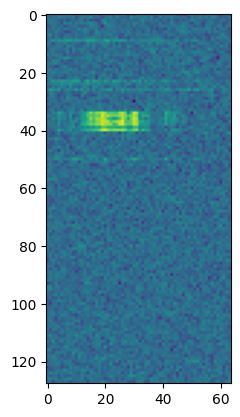

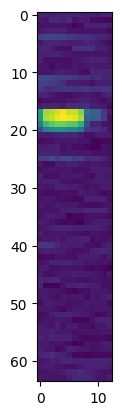

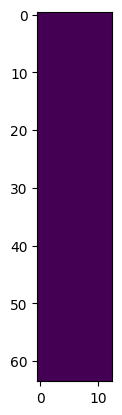

In [20]:
image = imageio.imread("data/testbed/BWZ/BWZ_30_2_1030.png")
image = image[64:]
image = image.T
print(image.shape)

plt.imshow(image)
plt.show()

downsampled = sp.downsample_spectrogram(image, 64)
downsampled = sp.digitize_spectrogram(downsampled)

augmented = sp.augment_spectrogram(downsampled, k=3, l=16, d=4)
painted = sp.paint_spectrogram(downsampled, augmented)

plt.imshow(augmented)
plt.show()

plt.imshow(painted)
plt.show()
